In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 08:56:32] [setup] RAM Tracking...
[codecarbon INFO @ 08:56:32] [setup] GPU Tracking...
[codecarbon INFO @ 08:56:32] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:56:32] [setup] CPU Tracking...
[codecarbon WARNING @ 08:56:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 08:56:35] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 08:56:35] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 08:56:35] >>> Tracker's metadata:
[codecarbon INFO @ 08:56:35]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 08:56:35]   Python version: 3.11.3
[codecarbon INFO @ 08:56:35]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 08:56:35]   Available RAM : 256.000 GB
[codecarbon INFO @ 08:56:35]   CPU count: 24
[codecarbon INFO @ 08:56:35]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb'
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [6]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


x1rgdduspxgr


In [7]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [9]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [10]:
full_training_df = pd.read_csv("../../csv/highest_vs_rest_balanced_jira.csv" , index_col = 0)
full_training_df


,text_clean,label,class_original
class,,,
highest,when we do range query on simple keys it does ...,1,Highest
highest,unhandledpromiserejectionwarning unhandled pro...,1,Highest
rest,the fabricunittestdaily branch failing intermi...,0,Medium
rest,as a system operator i want to receive alerts ...,0,Medium
rest,there is no support in datasourcetransactionma...,0,Medium
...,...,...,...
rest,once i have imported a widget into the store i...,0,Low
rest,the spec defines an axiom of a ie singleton li...,0,Medium
rest,to have an history on master of all csvs setup...,0,Medium


In [11]:

# Drop NaN values and reset index of dataframe
full_training_df = full_training_df[full_training_df['text_clean'].notna()]
full_training_df = full_training_df.rename(columns={'text_clean': 'text'})
full_training_df = full_training_df.reset_index()
full_training_df.drop(columns=["class", "class_original"], inplace=True)

In [12]:
full_training_df

,text,label
0,when we do range query on simple keys it does ...,1
1,unhandledpromiserejectionwarning unhandled pro...,1
2,the fabricunittestdaily branch failing intermi...,0
3,as a system operator i want to receive alerts ...,0
4,there is no support in datasourcetransactionma...,0
...,...,...
110711,once i have imported a widget into the store i...,0
110712,the spec defines an axiom of a ie singleton li...,0
110713,to have an history on master of all csvs setup...,0
110714,there are still some changes expected to be me...,1


In [13]:
fine_tuning_df = pd.read_csv("../../csv/clean_MongoDB_balanced.csv")
fine_tuning_df


,text_clean,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [14]:

fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [15]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [16]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [17]:
fine_tune_train_df

,text,label
1506,compile and dbtest work but theres a failure t...,1
680,add in specs for testing execute clean up spec...,0
135,give a client connected with the options coder...,0
408,it was removed in,0
591,paneltitledownstream change specific downstrea...,0
...,...,...
1444,im getting a strange misbehaviour during heavy...,1
1790,codephp manager new mongodbdrivermanagerdsn ar...,0
363,commands to reproduce mongo commands with fail...,1
923,backup agent released pass through explicit co...,1


In [18]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [19]:
df

,text,label
0,currently we are using usrshareelasticsearch a...,0
1,its been over hrs since the mirror has been up...,0
2,there has been discussion on the mailing lists...,0
3,when elytron client tries to obtain clientconf...,1
4,need to be able to release all items at once v...,1
...,...,...
94647,im getting a strange misbehaviour during heavy...,1
94648,codephp manager new mongodbdrivermanagerdsn ar...,0
94649,commands to reproduce mongo commands with fail...,1
94650,backup agent released pass through explicit co...,1


In [20]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [21]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        15934
       0        15617
1      0        15940
       1        15611
2      1        15815
       0        15735
Name: count, dtype: int64

In [22]:
df

,text,label,kfold
0,currently we are using usrshareelasticsearch a...,0,1
1,its been over hrs since the mirror has been up...,0,1
2,there has been discussion on the mailing lists...,0,1
3,when elytron client tries to obtain clientconf...,1,1
4,need to be able to release all items at once v...,1,1
...,...,...,...
94647,im getting a strange misbehaviour during heavy...,1,0
94648,codephp manager new mongodbdrivermanagerdsn ar...,0,0
94649,commands to reproduce mongo commands with fail...,1,2
94650,backup agent released pass through explicit co...,1,1


In [23]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [24]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [25]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [26]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [27]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [30]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [31]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [32]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [33]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [34]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1972/1972 [04:13<00:00,  7.78it/s, Epoch=1, LR=8.91e-6, Valid_Loss=0.582]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7312    0.6175    0.6695     15617
          HP     0.6747    0.7775    0.7225     15934

    accuracy                         0.6983     31551
   macro avg     0.7029    0.6975    0.6960     31551
weighted avg     0.7026    0.6983    0.6963     31551

Accuracy = 0.6983
F1_score = 0.7225
Validation Loss Improved (inf ---> 0.5820259837092645)
Model Saved



100%|██████████| 1972/1972 [04:13<00:00,  7.78it/s, Epoch=2, LR=6.18e-6, Valid_Loss=0.597]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7539    0.5885    0.6610     15617
          HP     0.6681    0.8117    0.7329     15934

    accuracy                         0.7012     31551
   macro avg     0.7110    0.7001    0.6970     31551
weighted avg     0.7106    0.7012    0.6973     31551

Accuracy = 0.7012
F1_score = 0.7329



100%|██████████| 1972/1972 [04:13<00:00,  7.79it/s, Epoch=3, LR=3.11e-6, Valid_Loss=0.575]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7228    0.6739    0.6975     15617
          HP     0.7003    0.7467    0.7227     15934

    accuracy                         0.7107     31551
   macro avg     0.7115    0.7103    0.7101     31551
weighted avg     0.7114    0.7107    0.7102     31551

Accuracy = 0.7107
F1_score = 0.7227
Validation Loss Improved (0.5820259837092645 ---> 0.5752379752135663)
Model Saved

Training complete in 1h 42m 39s
Best Loss: 0.5752


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁▃█
Valid F1_score,▁█▁
Valid Loss,▃█▁
Best Loss,0.57524
Train Loss,0.51424
Valid Accuracy,0.7107
Valid F1_score,0.7227
Valid Loss,0.57524



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1972/1972 [04:21<00:00,  7.55it/s, Epoch=1, LR=8.91e-6, Valid_Loss=0.583]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7390    0.5995    0.6620     15940
          HP     0.6571    0.7838    0.7149     15611

    accuracy                         0.6907     31551
   macro avg     0.6981    0.6917    0.6884     31551
weighted avg     0.6985    0.6907    0.6882     31551

Accuracy = 0.6907
F1_score = 0.7149
Validation Loss Improved (inf ---> 0.5831954845505272)
Model Saved



100%|██████████| 1972/1972 [04:20<00:00,  7.56it/s, Epoch=2, LR=6.18e-6, Valid_Loss=0.565]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7201    0.6918    0.7056     15940
          HP     0.6974    0.7254    0.7111     15611

    accuracy                         0.7084     31551
   macro avg     0.7087    0.7086    0.7084     31551
weighted avg     0.7089    0.7084    0.7084     31551

Accuracy = 0.7084
F1_score = 0.7111
Validation Loss Improved (0.5831954845505272 ---> 0.5647041997491363)
Model Saved



100%|██████████| 1972/1972 [04:21<00:00,  7.55it/s, Epoch=3, LR=3.11e-6, Valid_Loss=0.574]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7576    0.6075    0.6743     15940
          HP     0.6667    0.8015    0.7279     15611

    accuracy                         0.7035     31551
   macro avg     0.7121    0.7045    0.7011     31551
weighted avg     0.7126    0.7035    0.7008     31551

Accuracy = 0.7035
F1_score = 0.7279

Training complete in 1h 43m 3s
Best Loss: 0.5647


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁█▆
Valid F1_score,▃▁█
Valid Loss,█▁▅
Best Loss,0.5647
Train Loss,0.51643
Valid Accuracy,0.7035
Valid F1_score,0.7279
Valid Loss,0.5741



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1972/1972 [04:21<00:00,  7.55it/s, Epoch=1, LR=8.91e-6, Valid_Loss=0.586]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6670    0.7338    0.6988     15735
          HP     0.7058    0.6355    0.6688     15815

    accuracy                         0.6845     31550
   macro avg     0.6864    0.6847    0.6838     31550
weighted avg     0.6865    0.6845    0.6838     31550

Accuracy = 0.6845
F1_score = 0.6688
Validation Loss Improved (inf ---> 0.5861036244171735)
Model Saved



100%|██████████| 1972/1972 [04:21<00:00,  7.54it/s, Epoch=2, LR=6.18e-6, Valid_Loss=0.571]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7162    0.6522    0.6827     15735
          HP     0.6822    0.7429    0.7113     15815

    accuracy                         0.6977     31550
   macro avg     0.6992    0.6976    0.6970     31550
weighted avg     0.6992    0.6977    0.6971     31550

Accuracy = 0.6977
F1_score = 0.7113
Validation Loss Improved (0.5861036244171735 ---> 0.570968247056952)
Model Saved



100%|██████████| 1972/1972 [04:21<00:00,  7.54it/s, Epoch=3, LR=3.11e-6, Valid_Loss=0.576]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7058    0.7070    0.7064     15735
          HP     0.7080    0.7067    0.7074     15815

    accuracy                         0.7069     31550
   macro avg     0.7069    0.7069    0.7069     31550
weighted avg     0.7069    0.7069    0.7069     31550

Accuracy = 0.7069
F1_score = 0.7074

Training complete in 1h 42m 59s
Best Loss: 0.5710


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁▅█
Valid F1_score,▁█▇
Valid Loss,█▁▃
Best Loss,0.57097
Train Loss,0.50949
Valid Accuracy,0.7069
Valid F1_score,0.7074
Valid Loss,0.57593


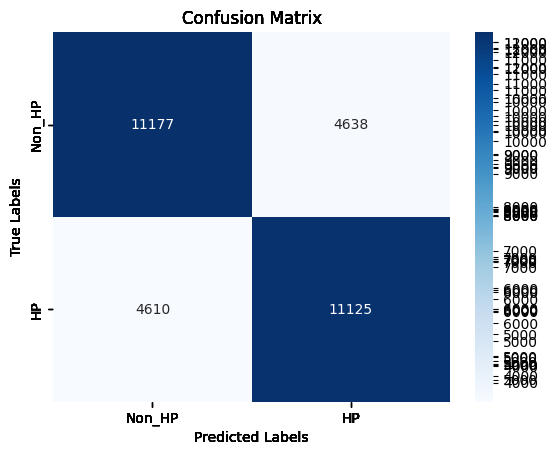

In [35]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [36]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [37]:
test_df = fine_tune_test_df

In [38]:
test_df

,text,label
1026,i have a replicaset with the primary running m...,1
1460,hi this is my first jira ticket so please forg...,1
1113,what problem are you facing i updated from v t...,1
707,introduced here after a network read error the...,1
857,hello compass allows transforming a document f...,0
...,...,...
1130,the secondaryreadspassthrough task on runs mon...,0
1294,engineering ticket descriptioni get better thr...,0
860,hi i have implemented the lab through mongo un...,1
1459,im not sure what the impact of this could be b...,0


In [39]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [40]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [41]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [42]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [43]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [44]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


Fold 1


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


Fold 2


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


In [45]:
deberta_predictions


[array([[0.08994859, 0.9100514 ],
        [0.05248875, 0.94751126],
        [0.10156073, 0.8984393 ],
        ...,
        [0.17047334, 0.82952666],
        [0.55253   , 0.44747   ],
        [0.39401615, 0.6059838 ]], dtype=float32),
 array([[0.1244771 , 0.8755229 ],
        [0.04604069, 0.95395935],
        [0.06860548, 0.93139446],
        ...,
        [0.20956151, 0.7904385 ],
        [0.4318795 , 0.5681205 ],
        [0.57339644, 0.42660353]], dtype=float32),
 array([[0.08266908, 0.9173309 ],
        [0.07500128, 0.9249987 ],
        [0.12873767, 0.8712624 ],
        ...,
        [0.25578234, 0.7442177 ],
        [0.54069495, 0.45930505],
        [0.666607  , 0.33339298]], dtype=float32)]

In [46]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.09903159, 0.9009684 ],
       [0.05784358, 0.9421565 ],
       [0.09963463, 0.90036535],
       ...,
       [0.21193905, 0.7880609 ],
       [0.50836813, 0.49163184],
       [0.5446732 , 0.45532677]], dtype=float32)

In [47]:
len(predictions)

1272

In [48]:
predictions

array([[0.09903159, 0.9009684 ],
       [0.05784358, 0.9421565 ],
       [0.09963463, 0.90036535],
       ...,
       [0.21193905, 0.7880609 ],
       [0.50836813, 0.49163184],
       [0.5446732 , 0.45532677]], dtype=float32)

In [49]:
test_df["prediction_0"] = predictions[:, 0] 

In [50]:
test_df["prediction_1"] = predictions[:, 1] 

In [51]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [52]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
1026,i have a replicaset with the primary running m...,1,0.099032,0.900968,1,1,1
1460,hi this is my first jira ticket so please forg...,1,0.057844,0.942156,1,1,1
1113,what problem are you facing i updated from v t...,1,0.099635,0.900365,1,1,1
707,introduced here after a network read error the...,1,0.203779,0.796221,1,1,1
857,hello compass allows transforming a document f...,0,0.347526,0.652474,1,1,1
...,...,...,...,...,...,...,...
1130,the secondaryreadspassthrough task on runs mon...,0,0.741103,0.258897,0,0,0
1294,engineering ticket descriptioni get better thr...,0,0.870321,0.129679,0,0,0
860,hi i have implemented the lab through mongo un...,1,0.211939,0.788061,1,1,1
1459,im not sure what the impact of this could be b...,0,0.508368,0.491632,0,1,0


In [53]:
len(test_df)

1272

In [54]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [55]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [56]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [57]:
test_df["pred"] = test_df["pred"].astype(int)

In [58]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
1026,i have a replicaset with the primary running m...,1,0.099032,0.900968,1,1,1,prediction_1,1
1460,hi this is my first jira ticket so please forg...,1,0.057844,0.942156,1,1,1,prediction_1,1
1113,what problem are you facing i updated from v t...,1,0.099635,0.900365,1,1,1,prediction_1,1
707,introduced here after a network read error the...,1,0.203779,0.796221,1,1,1,prediction_1,1
857,hello compass allows transforming a document f...,0,0.347526,0.652474,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
1130,the secondaryreadspassthrough task on runs mon...,0,0.741103,0.258897,0,0,0,prediction_0,0
1294,engineering ticket descriptioni get better thr...,0,0.870321,0.129679,0,0,0,prediction_0,0
860,hi i have implemented the lab through mongo un...,1,0.211939,0.788061,1,1,1,prediction_1,1
1459,im not sure what the impact of this could be b...,0,0.508368,0.491632,0,1,0,prediction_0,0


In [59]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[428 212]
 [227 405]]


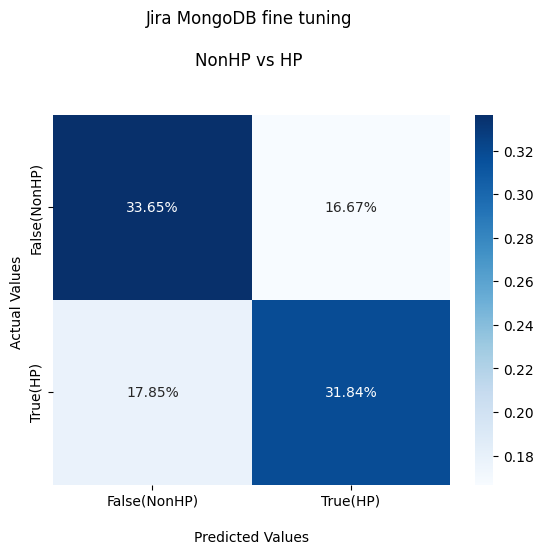

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Jira MongoDB fine tuning \n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [61]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       640
           1       0.66      0.64      0.65       632

    accuracy                           0.65      1272
   macro avg       0.65      0.65      0.65      1272
weighted avg       0.65      0.65      0.65      1272



In [62]:
test_df[["text","label","pred"]].to_csv("MongoDB_70_Test_inference.csv")

In [63]:
tracker.stop()

0.04813967417695393